In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from collections import Counter
import cv2
from sklearn.model_selection import train_test_split

In [2]:
# Path to the data directory
data_dir = Path("dataset/fake_captcha/captcha")

# Get list of all the images
images = list(data_dir.glob("*.png"))

num_images = len(images)

print("Number of images: ", num_images)

Number of images:  5000


Shape of images:  (50, 150, 3)


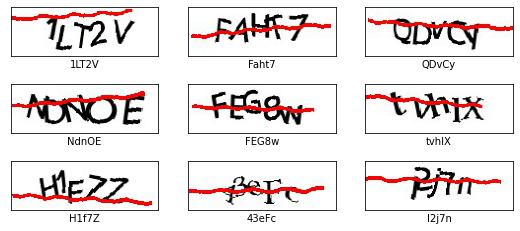

In [3]:
plt.figure(figsize=(9,4))
random_images = random.sample(range(num_images), 9)
print("Shape of images: ", mpimg.imread(str(images[random_images[0]]),0).shape)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mpimg.imread(str(images[random_images[i]]),0))
    plt.xlabel(str(images[random_images[i]]).split('\\')[-1].split('.')[0])
plt.show()

In [4]:
# Store all the characters in a set
characters = set()

# A list to store the length of each captcha
captcha_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 2. Store the length of this cpatcha
    captcha_length.append(len(label))
    # 3. Store the image-label pair info
    dataset.append((str(img_path), label))
    
    # 4. Store the characters present
    for ch in label:
        characters.add(ch)

# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)


print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Number of unqiue charcaters in the whole dataset:  61
Maximum length of any captcha:  5
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total number of samples in the dataset:  5000


,img_path,label
0,dataset\fake_captcha\captcha\vhBeS.png,vhBeS
1,dataset\fake_captcha\captcha\oeLBi.png,oeLBi
2,dataset\fake_captcha\captcha\nAVxd.png,nAVxd
3,dataset\fake_captcha\captcha\xHfCZ.png,xHfCZ
4,dataset\fake_captcha\captcha\lyF8M.png,lyF8M


In [5]:
training_data, validation_data = train_test_split(dataset, test_size=0.2)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))

Number of training samples:  4000
Number of validation samples:  1000


In [6]:
# Map text to numeric labels 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Map numeric labels to text
labels_to_char = {val:key for key, val in char_to_labels.items()}

In [7]:
# Sanity check for corrupted images
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True


In [8]:
# Store arrays in memory as it's not a muvh big dataset
def generate_arrays(df, resize=True, img_height=50, img_width=150):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Add only if it is a valid captcha
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)

In [9]:
# Build training data
training_data, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)

Number of training images:  (4000, 50, 150)
Number of training labels:  (4000,)


In [10]:
# Build validation data
validation_data, validation_labels = generate_arrays(df=validation_data)
print("Number of validation images: ", validation_data.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of validation images:  (1000, 50, 150)
Number of validation labels:  (1000,)


In [11]:
class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset.
    
    Args:
        data: training or validation data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any captcha
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs 
        batch_labels: a batch of corresponding labels 
    """
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=200,
                 img_height=50,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
        
        # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the captcha is valid
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [12]:
batch_size = 16

# Desired image dimensions
img_width=150
img_height=50 

# Factor  by which the image is going to be downsampled
# by the convolutional blocks
downsample_factor=4

# Maximum length of any captcha in the data
max_length=5

# Get a generator object for the training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Get a generator object for the validation data 
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

In [13]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss



def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # First conv block
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Second conv block
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=sgd)
    return model

In [14]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 150, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 50, 32)  320         input_data[0][0]                 
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 75, 25, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 75, 25, 64)   18496       pool1[0][0]                      
_______________________________________________________________________________________

In [33]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=100,
                    callbacks=[es])

Epoch 1/100
250/250 [==============================] - 38s 151ms/step - loss: 6.4240 - val_loss: 9.6293
Epoch 2/100
250/250 [==============================] - 44s 176ms/step - loss: 6.2694 - val_loss: 9.7118
Epoch 3/100
250/250 [==============================] - 56s 224ms/step - loss: 6.1789 - val_loss: 9.6907
Epoch 4/100
250/250 [==============================] - 60s 242ms/step - loss: 6.0730 - val_loss: 9.5184
Epoch 5/100
250/250 [==============================] - 58s 231ms/step - loss: 5.9808 - val_loss: 9.6341
Epoch 6/100
250/250 [==============================] - 44s 176ms/step - loss: 5.8627 - val_loss: 9.5561
Epoch 7/100
250/250 [==============================] - 42s 168ms/step - loss: 5.7775 - val_loss: 9.8288
Epoch 8/100
250/250 [==============================] - 41s 165ms/step - loss: 5.6948 - val_loss: 9.6647
Epoch 9/100
250/250 [==============================] - 41s 163ms/step - loss: 5.6092 - val_loss: 9.7215


In [34]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 150, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 150, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 75, 25, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 75, 25, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 37, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 37, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 37, 64)            4921

In [35]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

In [36]:
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

Ground truth: Ew6sj 	 Predicted: Evo5j
Ground truth: 21Wa0 	 Predicted: 2MW80
Ground truth: WcdoE 	 Predicted: wCDoE
Ground truth: Zctl8 	 Predicted: ZiI8
Ground truth: Ywln5 	 Predicted: YwHNB
Ground truth: Div0C 	 Predicted: DivC
Ground truth: hWAqF 	 Predicted: hM4rF
Ground truth: yiCHQ 	 Predicted: VCjIO
Ground truth: dAnM9 	 Predicted: dam8
Ground truth: 6jL29 	 Predicted: 6jL23
Ground truth: isOXB 	 Predicted: lCOvP
Ground truth: fowWN 	 Predicted: rowW
Ground truth: HoNW8 	 Predicted: Hamw8
Ground truth: 9QWd4 	 Predicted: SgWqA
Ground truth: DG5P9 	 Predicted: dC3Po
Ground truth: aErTt 	 Predicted: AEbT


In [26]:
# Path to the data directory
car_dir = Path("dataset/car_captcha")

# Get list of all the images
images = list(car_dir.glob("*.png"))

num_images = len(images)

print("Number of images: ", num_images)

Number of images:  14


Shape of images:  (50, 150, 4)


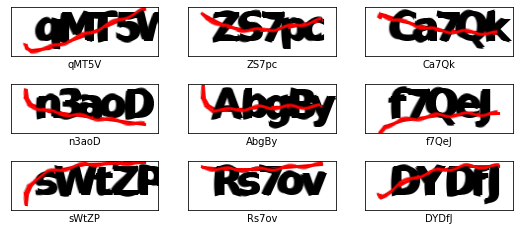

In [27]:
plt.figure(figsize=(9,4))
random_images = random.sample(range(num_images), 9)
print("Shape of images: ", mpimg.imread(str(images[random_images[0]]),0).shape)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mpimg.imread(str(images[random_images[i]]),0))
    plt.xlabel(str(images[random_images[i]]).split('\\')[-1].split('.')[0])
plt.show()